In [18]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from typing import Any, Optional, Tuple, Type


In [2]:
# From https://github.com/facebookresearch/detectron2/blob/main/detectron2/layers/batch_norm.py # noqa
# Itself from https://github.com/facebookresearch/ConvNeXt/blob/d1fa8f6fef0a165b27399986cc2bdacc92777e40/models/convnext.py#L119  # noqa
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x

In [3]:
import numpy as np
import torch
from torch.nn import functional as F
from torchvision.transforms.functional import resize, to_pil_image  # type: ignore

from copy import deepcopy
from typing import Tuple


class ResizeLongestSide:
    """
    Resizes images to the longest side 'target_length', as well as provides
    methods for resizing coordinates and boxes. Provides methods for
    transforming both numpy array and batched torch tensors.
    """

    def __init__(self, target_length: int) -> None:
        self.target_length = target_length

    def apply_image(self, image: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        target_size = self.get_preprocess_shape(image.shape[0], image.shape[1], self.target_length)
        return np.array(resize(to_pil_image(image), target_size))

    def apply_coords(self, coords: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes(self, boxes: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array shape Bx4. Requires the original image size
        in (H, W) format.
        """
        boxes = self.apply_coords(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    def apply_image_torch(self, image: torch.Tensor) -> torch.Tensor:
        """
        Expects batched images with shape BxCxHxW and float format. This
        transformation may not exactly match apply_image. apply_image is
        the transformation expected by the model.
        """
        # Expects an image in BCHW format. May not exactly match apply_image.
        target_size = self.get_preprocess_shape(image.shape[2], image.shape[3], self.target_length)
        return F.interpolate(
            image, target_size, mode="bilinear", align_corners=False, antialias=True
        )

    def apply_coords_torch(
        self, coords: torch.Tensor, original_size: Tuple[int, ...]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with length 2 in the last dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).to(torch.float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes_torch(
        self, boxes: torch.Tensor, original_size: Tuple[int, ...]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with shape Bx4. Requires the original image
        size in (H, W) format.
        """
        boxes = self.apply_coords_torch(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    @staticmethod
    def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
        """
        Compute the output size given input size and target long side length.
        """
        scale = long_side_length * 1.0 / max(oldh, oldw)
        newh, neww = oldh * scale, oldw * scale
        neww = int(neww + 0.5)
        newh = int(newh + 0.5)
        return (newh, neww)



# Random Fourier Features for 2D Positional Encoding

* $\mathbf{A} \in \mathbb{R}^{2 \times D}$ be a random matrix (each entry drawn from a normal distribution). `D` is typically $\frac{prompt\_embed\_dim}{2}$, it is set as `256` in SAM. 
* A 2D point  $\mathbf{x} = (x, y) \in [0,1]^2$ is first remapped from $[0,1]^2 \text{to} [-1,1]^2$:$\mathbf{x}' = 2\,\mathbf{x} - 1.$
* We define
$
  \mathbf{z}(\mathbf{x}) \;=\; 2\pi\,\mathbf{x}'\,\mathbf{A}
  \;=\; 2\pi\,(2\mathbf{x} - 1)\,\mathbf{A} \;\;\in \mathbb{R}^D.
$
* The positional embedding is then formed by concatenating sine and cosine:
$
  PE(\mathbf{x}) 
  \;=\;
  \begin{bmatrix}
    \sin\bigl(\mathbf{z}(\mathbf{x})\bigr) \\
    \cos\bigl(\mathbf{z}(\mathbf{x})\bigr)
  \end{bmatrix}
  \;\in\;\mathbb{R}^{2D}.
$

# Grid Coordinates
* Suppose we generate a grid of size $\text{(height } H\text{)} \times \text{(width } W\text{)}$. $H \times W = image\_embedding\_size \times image\_embedding\_size $ or in this case, $64\times64$
* For each grid location $(i,j), \text{with} i = 0,\dots,H-1 \text{and} j = 0,\dots,W-1$, we treat the "center" of each cell as 
$
  x_{i,j} \;=\; \frac{j + 0.5}{W}, 
  \quad
  y_{i,j} \;=\; \frac{i + 0.5}{H}.
$
* Hence the 2D point becomes 
$ \mathbf{x}_{i,j} = (x_{i,j},\,y_{i,j})\in [0,1]^2$,
and its positional embedding is
$
  PE\bigl(\mathbf{x}_{i,j}\bigr)
  \;=\;
  \begin{bmatrix}
    \sin\bigl(2\pi\,(2\mathbf{x}_{i,j}-1)\,\mathbf{A}\bigr)\\
    \cos\bigl(2\pi\,(2\mathbf{x}_{i,j}-1)\,\mathbf{A}\bigr)
  \end{bmatrix}.
$
* Stacking all embeddings yields a tensor of shape
$
  \;H\;\times\;W\;\times (2D),
$
* corresponding to
$\sin \text{and} \cos$ features over the 2D grid. Note that $D$ is `prompt_embed_dims` which is `256`.

# Code
`self.register_buffer("positional_encoding_gaussian_matrix",scale * torch.randn((2, num_pos_feats))), #num_pos_feats=128, 256/2`

`h, w = (64,64)`

`grid = torch.ones((h, w), device=device, dtype=torch.float32)`

`y_embed = grid.cumsum(dim=0) - 0.5`
```
tensor([[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 2.,  2.,  2.,  ...,  2.,  2.,  2.],
        [ 3.,  3.,  3.,  ...,  3.,  3.,  3.],     -  0.5
        ...,
        [62., 62., 62.,  ..., 62., 62., 62.],
        [63., 63., 63.,  ..., 63., 63., 63.],
        [64., 64., 64.,  ..., 64., 64., 64.]])
```

`x_embed = grid.cumsum(dim=1) - 0.5`
```
tensor([[ 1.,  2.,  3.,  ..., 62., 63., 64.],
        [ 1.,  2.,  3.,  ..., 62., 63., 64.],
        [ 1.,  2.,  3.,  ..., 62., 63., 64.],     - 0.5
        ...,
        [ 1.,  2.,  3.,  ..., 62., 63., 64.],
        [ 1.,  2.,  3.,  ..., 62., 63., 64.],
        [ 1.,  2.,  3.,  ..., 62., 63., 64.]])
```

`y_embed = y_embed / h`

`x_embed = x_embed / w`

`coords = 2 * coords - 1 ##64x64x2`

`coords = coords @ self.positional_encoding_gaussian_matrix ##64x64x2 X 2x128 = 64x64x128`

`coords = 2 * np.pi * coords # outputs d_1 x ... x d_n x C shape`

`torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1) ## 64x64x256 ` 



In [36]:
grid = torch.ones((64, 64), device='cpu', dtype=torch.float32)

y_embed = grid.cumsum(dim=1)  ##torch.tensor([1, 2, 3, 4])`
print(y_embed)

tensor([[ 1.,  2.,  3.,  ..., 62., 63., 64.],
        [ 1.,  2.,  3.,  ..., 62., 63., 64.],
        [ 1.,  2.,  3.,  ..., 62., 63., 64.],
        ...,
        [ 1.,  2.,  3.,  ..., 62., 63., 64.],
        [ 1.,  2.,  3.,  ..., 62., 63., 64.],
        [ 1.,  2.,  3.,  ..., 62., 63., 64.]])


In [ ]:
class PositionEmbeddingRandom(nn.Module):
    """
    Positional encoding using random spatial frequencies.
    """

    def __init__(self, num_pos_feats: int = 64, scale: Optional[float] = None) -> None:
        super().__init__()
        if scale is None or scale <= 0.0:
            scale = 1.0
        self.register_buffer(
            "positional_encoding_gaussian_matrix",
            scale * torch.randn((2, num_pos_feats)), #num_pos_feats=128, 256/2
        )

    def _pe_encoding(self, coords: torch.Tensor) -> torch.Tensor:
        """Positionally encode points that are normalized to [0,1]."""
        # assuming coords are in [0, 1]^2 square and have d_1 x ... x d_n x 2 shape
        print(coords.shape)
        coords = 2 * coords - 1 ##64x64x2
        coords = coords @ self.positional_encoding_gaussian_matrix ##64x64x128
        coords = 2 * np.pi * coords
        # outputs d_1 x ... x d_n x C shape
        return torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1)

    def forward(self, size: Tuple[int, int]) -> torch.Tensor:
        """Generate positional encoding for a grid of the specified size."""
        h, w = size
        device: Any = self.positional_encoding_gaussian_matrix.device
        grid = torch.ones((h, w), device=device, dtype=torch.float32)
        y_embed = grid.cumsum(dim=0) - 0.5
        x_embed = grid.cumsum(dim=1) - 0.5
        y_embed = y_embed / h
        x_embed = x_embed / w
        print(x_embed.shape, y_embed.shape)
        pe = self._pe_encoding(torch.stack([x_embed, y_embed], dim=-1))
        return pe.permute(2, 0, 1)  # C x H x W

    def forward_with_coords(
        self, coords_input: torch.Tensor, image_size: Tuple[int, int]
    ) -> torch.Tensor:
        """Positionally encode points that are not normalized to [0,1]."""
        coords = coords_input.clone()
        coords[:, :, 0] = coords[:, :, 0] / image_size[1]
        coords[:, :, 1] = coords[:, :, 1] / image_size[0]
        return self._pe_encoding(coords.to(torch.float))  # B x N x C

In [32]:
class PromptEncoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        image_embedding_size: Tuple[int, int],
        input_image_size: Tuple[int, int],
        mask_in_chans: int,
        activation: Type[nn.Module] = nn.GELU,
    ) -> None:
        """
        Encodes prompts for input to SAM's mask decoder.

        Arguments:
          embed_dim (int): The prompts' embedding dimension
          image_embedding_size (tuple(int, int)): The spatial size of the
            image embedding, as (H, W).
          input_image_size (int): The padded size of the image as input
            to the image encoder, as (H, W).
          mask_in_chans (int): The number of hidden channels used for
            encoding input masks.
          activation (nn.Module): The activation to use when encoding
            input masks.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.input_image_size = input_image_size
        self.image_embedding_size = image_embedding_size
        self.pe_layer = PositionEmbeddingRandom(embed_dim // 2)

        self.num_point_embeddings: int = 4  # pos/neg point + 2 box corners
        point_embeddings = [nn.Embedding(1, embed_dim) for i in range(self.num_point_embeddings)]
        self.point_embeddings = nn.ModuleList(point_embeddings)
        self.not_a_point_embed = nn.Embedding(1, embed_dim)

        self.mask_input_size = (4 * image_embedding_size[0], 4 * image_embedding_size[1])
        self.mask_downscaling = nn.Sequential(
            nn.Conv2d(1, mask_in_chans // 4, kernel_size=2, stride=2),
            LayerNorm2d(mask_in_chans // 4),
            activation(),
            nn.Conv2d(mask_in_chans // 4, mask_in_chans, kernel_size=2, stride=2),
            LayerNorm2d(mask_in_chans),
            activation(),
            nn.Conv2d(mask_in_chans, embed_dim, kernel_size=1),
        )
        self.no_mask_embed = nn.Embedding(1, embed_dim)

    def get_dense_pe(self) -> torch.Tensor:
        """
        Returns the positional encoding used to encode point prompts,
        applied to a dense set of points the shape of the image encoding.

        Returns:
          torch.Tensor: Positional encoding with shape
            1x(embed_dim)x(embedding_h)x(embedding_w)
        """
        return self.pe_layer(self.image_embedding_size).unsqueeze(0)

    def _embed_points(
        self,
        points: torch.Tensor,
        labels: torch.Tensor,
        pad: bool,
    ) -> torch.Tensor:
        """Embeds point prompts."""
        points = points + 0.5  # Shift to center of pixel
        if pad:
            padding_point = torch.zeros((points.shape[0], 1, 2), device=points.device)
            padding_label = -torch.ones((labels.shape[0], 1), device=labels.device)
            points = torch.cat([points, padding_point], dim=1)
            labels = torch.cat([labels, padding_label], dim=1)
        point_embedding = self.pe_layer.forward_with_coords(points, self.input_image_size)
        point_embedding[labels == -1] = 0.0
        point_embedding[labels == -1] += self.not_a_point_embed.weight
        point_embedding[labels == 0] += self.point_embeddings[0].weight
        point_embedding[labels == 1] += self.point_embeddings[1].weight
        return point_embedding

    def _embed_boxes(self, boxes: torch.Tensor) -> torch.Tensor:
        """Embeds box prompts."""
        boxes = boxes + 0.5  # Shift to center of pixel
        coords = boxes.reshape(-1, 2, 2)
        corner_embedding = self.pe_layer.forward_with_coords(coords, self.input_image_size)
        corner_embedding[:, 0, :] += self.point_embeddings[2].weight
        corner_embedding[:, 1, :] += self.point_embeddings[3].weight
        return corner_embedding

    def _embed_masks(self, masks: torch.Tensor) -> torch.Tensor:
        """Embeds mask inputs."""
        mask_embedding = self.mask_downscaling(masks)
        return mask_embedding

    def _get_batch_size(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
    ) -> int:
        """
        Gets the batch size of the output given the batch size of the input prompts.
        """
        if points is not None:
            return points[0].shape[0]
        elif boxes is not None:
            return boxes.shape[0]
        elif masks is not None:
            return masks.shape[0]
        else:
            return 1

    def _get_device(self) -> torch.device:
        return self.point_embeddings[0].weight.device

    def forward(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Embeds different types of prompts, returning both sparse and dense
        embeddings.

        Arguments:
          points (tuple(torch.Tensor, torch.Tensor) or none): point coordinates
            and labels to embed.
          boxes (torch.Tensor or none): boxes to embed
          masks (torch.Tensor or none): masks to embed

        Returns:
          torch.Tensor: sparse embeddings for the points and boxes, with shape
            BxNx(embed_dim), where N is determined by the number of input points
            and boxes.
          torch.Tensor: dense embeddings for the masks, in the shape
            Bx(embed_dim)x(embed_H)x(embed_W)
        """
        bs = self._get_batch_size(points, boxes, masks)
        sparse_embeddings = torch.empty((bs, 0, self.embed_dim), device=self._get_device())
        if points is not None:
            coords, labels = points
            point_embeddings = self._embed_points(coords, labels, pad=(boxes is None))
            sparse_embeddings = torch.cat([sparse_embeddings, point_embeddings], dim=1)
        if boxes is not None:
            box_embeddings = self._embed_boxes(boxes)
            sparse_embeddings = torch.cat([sparse_embeddings, box_embeddings], dim=1)

        if masks is not None:
            dense_embeddings = self._embed_masks(masks)
        else:
            dense_embeddings = self.no_mask_embed.weight.reshape(1, -1, 1, 1).expand(
                bs, -1, self.image_embedding_size[0], self.image_embedding_size[1]
            )

        return sparse_embeddings, dense_embeddings


In [33]:
prompt_embed_dim = 256
image_size = 1024
vit_patch_size = 16
image_embedding_size = image_size // vit_patch_size

pe_layer = PositionEmbeddingRandom(prompt_embed_dim//2)
pes = pe_layer((image_embedding_size, image_embedding_size)).cpu().numpy()
print(pes.shape)

torch.Size([64, 64]) torch.Size([64, 64])
torch.Size([64, 64, 2])
(256, 64, 64)


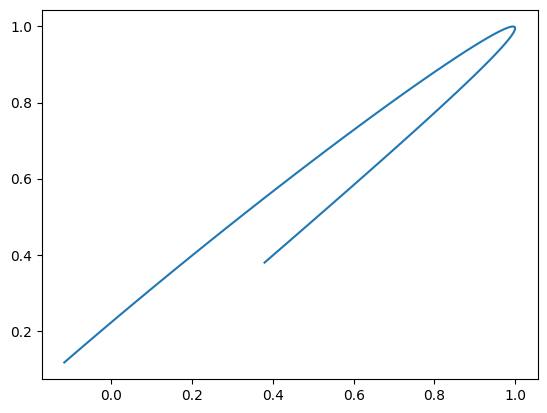

In [29]:
plt.plot(pes[0,:,0], pes[0,0,:], )

In [ ]:
img_transform_size = 1024
original_size = (480, 640)
transform = ResizeLongestSide(img_transform_size)

In [ ]:
use_point_coords = 1
use_box = 0
use_mask_input = 0
point_coords = np.array([240, 320])
point_coords = point_coords.reshape(1,2)
point_labels = [1]
box = 0
mask_input = 0
coords_torch = None
labels_torch = None
box_torch = None
mask_input_torch = None
if use_point_coords:
    point_coords = transform.apply_coords(point_coords, original_size)
    coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device='cpu')
    labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device='cpu')
    coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
if use_box:
    box = self.transform.apply_boxes(box, self.original_size)
    box_torch = torch.as_tensor(box, dtype=torch.float, device=self.device)
    box_torch = box_torch[None, :]
if use_mask_input:
    mask_input_torch = torch.as_tensor(mask_input, dtype=torch.float, device=self.device)
    mask_input_torch = mask_input_torch[None, :, :, :]

In [ ]:
print(coords_torch, labels_torch, coords_torch.shape, labels_torch.shape)

In [ ]:
prompt_embed_dim = 256
image_size = 1024
vit_patch_size = 16
image_embedding_size = image_size // vit_patch_size

prompt_encoder=PromptEncoder(
    embed_dim=prompt_embed_dim,
    image_embedding_size=(image_embedding_size, image_embedding_size),
    input_image_size=(image_size, image_size),
    mask_in_chans=16,)

In [ ]:
points = (coords_torch, labels_torch)
sparse_embeddings, dense_embeddings = prompt_encoder(
    points=points,
    boxes=box_torch,
    masks=mask_input_torch,
)